In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as sp
import scipy.stats as ss
import pymc3 as pm
import arviz as az
import seaborn as sns
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
sns.set(color_codes=True)
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')

plt.rcParams['figure.figsize'] = [5, 3]
from datetime import timedelta

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
data = pd.read_csv(r"C:\Users\Muc\Downloads\3DCi_1611_2011.csv")
df = data.copy()
df['act_date'] = pd.to_datetime(df.act_date)
df['day0_date'] = pd.to_datetime(df.day0_date)


In [3]:
def preprocess(data, day_window = 3, **kwargs):
    #cast day0date and act date to date
    data.loc[:,'day0_date'] = pd.to_datetime(data.loc[:,'day0_date'])
    data.loc[:,'act_date'] = pd.to_datetime(data.loc[:,'act_date'])
    if (data.act_date.max() - data.day0_date.min()) > timedelta(3):
        data = data[data.loc[:,'act_date'] < data.loc[:,'act_date'].max()] #drop max act_date 
        data = data[data.loc[:,'day0_date'] <= data.loc[:,'act_date'].max()-timedelta(days=day_window)] #find range day0_date
        data = data[(data.loc[:,'day_diff'] <= day_window) & (data.loc[:,'day_diff']>= 0)]

    for key, value in kwargs.items():
        data = data[data.loc[:,key] == value]
    
    data['combined_ad'] = data['rv_imp_sum'] * 1.3 + data['is_imp_sum']
    return data

def get_abtest_data(df, target, **kwargs):
    ab_data = preprocess(df, **kwargs)
    ab_data = ab_data.groupby('resettable_device_id_or_app_instance_id')[target].sum().reset_index(drop=True)
    return ab_data

def gameinfo(df, METRICS, **kwargs):
    data = preprocess(df, day_window = 3, **kwargs)
    data_by_day_diff = data.groupby('day_diff')[METRICS].sum()
    data_by_day_diff.loc['Grand Total'] = data_by_day_diff.iloc[:,1:].sum()

    data_per_dau = data_by_day_diff.copy()
    data_per_dau.iloc[:-1,1:] = data_per_dau.iloc[:-1,1:].div(data_per_dau.iloc[:-1,0], axis=0)
    data_per_dau.iloc[-1,1:] = data_per_dau.iloc[-1,1:]/data_per_dau.iloc[0,0]
    data_per_dau['dau'] = data_per_dau['dau']/data_per_dau.iloc[0,0]
    data_per_dau = data_per_dau.style.format({'dau': "{:.2%}"})
    return data_by_day_diff

In [10]:
# from preprocess import preprocess, gameinfo, get_abtest_data
# import bayes
# a_filter = {
#     'app_version' : '1.0.6' 
#     ,'country' : 'United States'
#     # ,'experiment_group':'firebase_exp_5_group0'
#     # ,'media_source' : 'Organic'
#     ,'event_segment' : 'app_update--FALSE' 
#     }                                                                   

# b_filter = {
#     'app_version' : '1.0.7' 
#     ,'country' : 'United States'
#     # ,'experiment_group':'firebase_exp_1_group1'
#     # ,'media_source' : 'Organic'
#     ,'event_segment' : 'app_update--FALSE' 
#     }
# metrics =  ['dau','time_in_game_sum','rv_imp_sum', 'is_imp_sum', 'combined_ad']
group0 = get_abtest_data(df, metrics, **a_filter)
group1  = get_abtest_data(df, metrics, **b_filter)

NameError: name 'a_filter' is not defined

In [10]:
a = {
    'country' : 'United States'
    # ,'app_version' : '1.1.3' 
    ,'experiment_group':'firebase_exp_1_group0'
    # ,'media_source' : "Organic"                                       
    # ,'event_segment' : 'app_update--FALSE' 
    }                                                                   
b = {
    'country' : 'United States' 
    # ,'app_version' : '1.1.3' 
    ,'experiment_group':'firebase_exp_1_group1'
    # ,'media_source' : 'Organic'
    # ,'event_segment' : 'app_update--FALSE' 
    }
metrics =  ['dau','time_in_game_sum','rv_imp_sum', 'is_imp_sum', 'combined_ad', 'battle_play_sum', 'battle_end_sum', 'ad_value_sum']
pd.DataFrame(gameinfo(df, metrics, **b))
group0 = get_abtest_data(df, metrics, **a)
group1  = get_abtest_data(df, metrics, **b)

array([<AxesSubplot:title={'center':'group0'}>,
       <AxesSubplot:title={'center':'group1'}>], dtype=object)

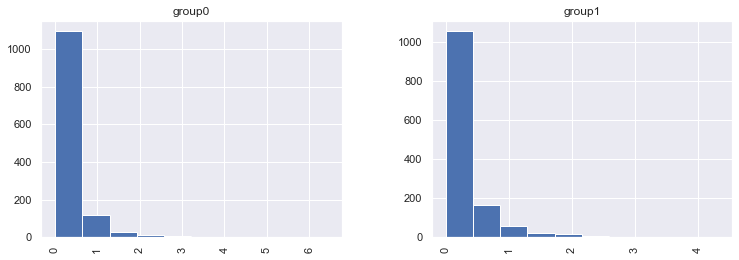

In [11]:
target = 'ad_value_sum'
y = pd.DataFrame(dict(target = np.r_[group0[target], group1[target]], group = np.r_[["group0"] * len(group0), ["group1"] * len(group1)])).rename({'target':target}, axis=1)
y.hist(target, by="group", figsize=(12, 4))

In [12]:
target_value = y[target].values
group_idx, groups = y['group'].factorize(sort=True)
COORDS = {
    'obs': y.index,
    'group': groups
}

with pm.Model(coords=COORDS) as model:
    # Hyperpriors:
    # Prior distribution for mu.
    mu = pm.Gamma('mu', alpha=2.0, beta=1.0/5)
    # Prior distribution for sigma2.
    sigma = pm.Exponential('sigma', 1.0)
    # Parametrization for the shape parameter.
    alpha =  pm.Deterministic('alpha', mu**2 / sigma**2)
    # Parametrization for the scale parameter.
    beta = pm.Deterministic('beta', mu / sigma**2)
    # Prior distribution for lambda.
    lam = pm.Gamma(
        'lam', 
        alpha=alpha, 
        beta=beta, 
        dims='group'
    )
    # Likehood function.
    rate = lam[group_idx]
    likelihood = pm.Poisson(
        'likelihood',
        mu=rate,
        observed=target_value,
        dims='obs'
    )
    difference = pm.Deterministic('difference_of_lam',lam[0] - lam[1])
    # Sample prior distribution.
    prior_predictive = pm.sample_prior_predictive()
    traces = pm.sample(
        draws=2000, chains=4 , return_inferencedata=True
    )
    posterior_predictive = az.from_pymc3(
        posterior_predictive=pm.sample_posterior_predictive(trace = traces)
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lam, sigma, mu]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 34 seconds.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 82 divergences after tuning. Increase `target_accept` or reparameterize.
There were 85 divergences after tuning. Increase `target_accept` or reparameterize.
There were 87 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


0, dim: obs, 2586 =? 2586


array([[<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'lam\ngroup0'}>,
        <AxesSubplot:title={'center':'lam\ngroup1'}>],
       [<AxesSubplot:title={'center':'difference_of_lam'}>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

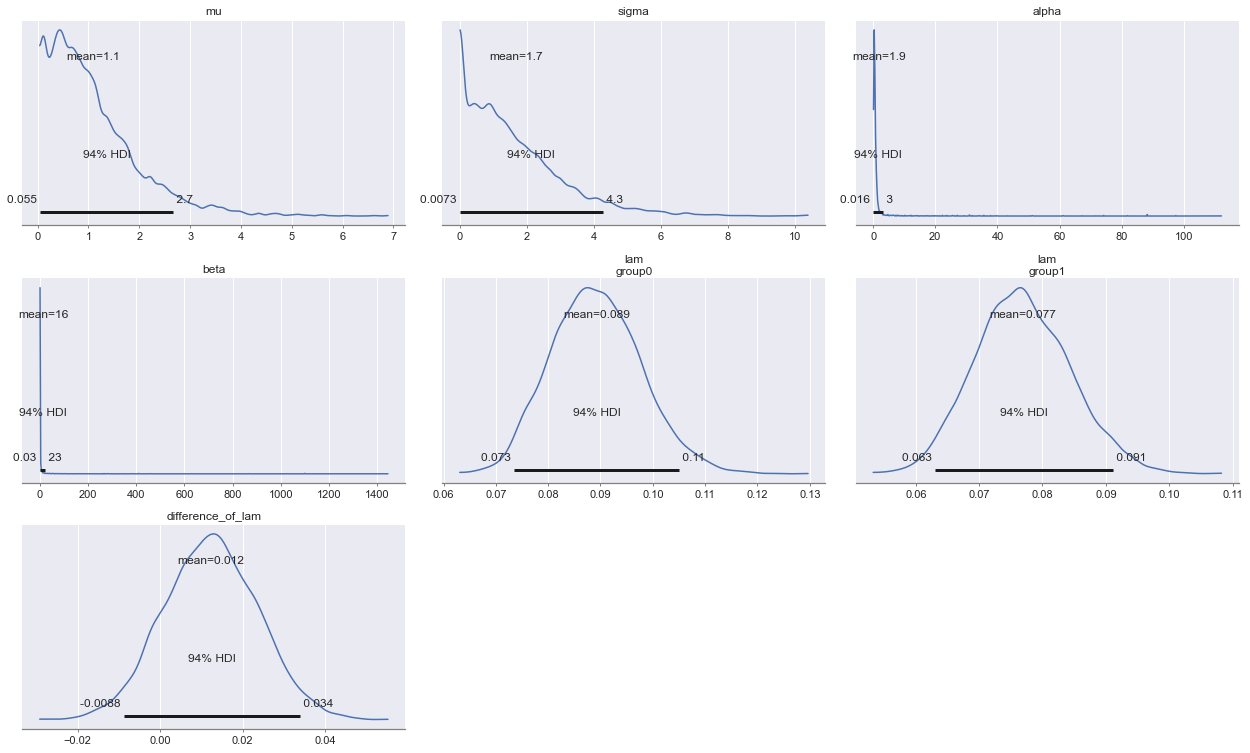

In [13]:
az.plot_posterior(traces)

array([[<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'mu'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>],
       [<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>],
       [<AxesSubplot:title={'center':'lam'}>,
        <AxesSubplot:title={'center':'lam'}>],
       [<AxesSubplot:title={'center':'difference_of_lam'}>,
        <AxesSubplot:title={'center':'difference_of_lam'}>]], dtype=object)

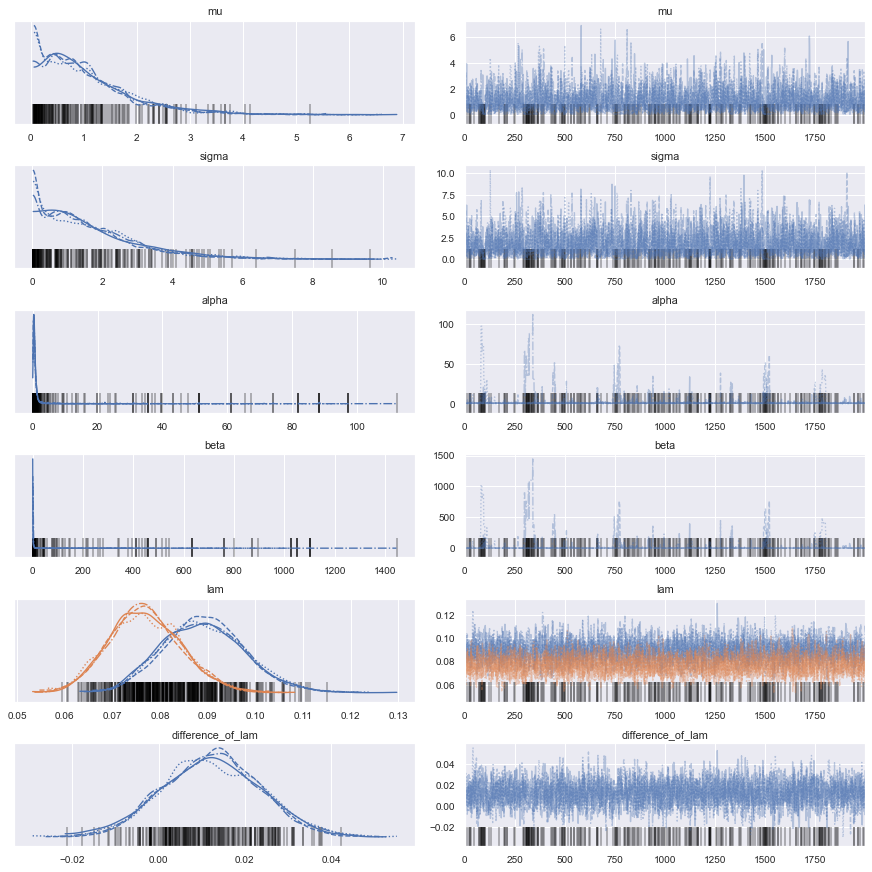

In [14]:
az.plot_trace(traces)

In [98]:
# Set location.
diff = traces \
    .posterior \
    .stack(sample=('chain', 'draw')) \
    ['difference_of_lam'].values

In [100]:
(diff > 0).mean()

0.0

In [11]:
# Set location.
lam0 = traces \
    .posterior \
    .stack(sample=('chain', 'draw')) \
    ['lam'][0, :].values

lam1 = traces \
    .posterior \
    .stack(sample=('chain', 'draw')) \
    ['lam'][1, :].values

SEED = 29
np.random.seed(SEED)
# Sample from Poisson distribution using posterior samples from lambda.
samples0 = np.random.poisson(lam=lam0)
samples1 = np.random.poisson(lam=lam1)

(samples1 > samples0).astype(float).mean()

1.0

In [26]:
from functools import reduce

In [22]:
samples = list(zip(lam0, lam1))

In [32]:
diff_list = map(lambda sample: np.max([(sample[0]-sample[1])/sample[1], 0]), samples)

In [30]:
diff_list

In [33]:
sum_diff = reduce(lambda x,y:x+y, diff_list)

In [34]:
sum_diff/8000

0.02551756548889951

In [11]:
(lam1 < lam0).mean()

0.970375

In [19]:
((lam0 - lam1)/lam1).mean()

0.025419249260651786

In [14]:
(((lam1 - lam0)/lam0)).mean()

-0.024623770989483845

In [18]:
((lam0-lam1)/lam1).mean()

0.025419249260651786

In [16]:
max((lam0-lam1)/lam1,0).mean()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [160]:
(lam0 < lam1).all()

True

In [157]:
((lam0 - lam1)/(lam1)).mean()

-0.08351670464499976

In [ ]:
diff_list = map(lambda sample: np.max([sample[0]-sample[1], 0]), samples)

In [12]:
((lam1 - lam0)/lam0).mean()

-0.024623770989483845

In [150]:
lam0 - lam1)

array([0.6083731 , 0.61487446, 0.55192519, ..., 0.61538613, 0.46397043,
       0.52333542])

In [149]:
(samples0 > samples1 ).mean()

0.499125

In [78]:
samples_0 = posterior_predictive \
    .posterior_predictive \
    .stack(sample=('chain', 'draw')) \
    ['likelihood'][groups[group_idx] == 'group0'] \
    .values \
    .flatten()

samples_1 = posterior_predictive \
    .posterior_predictive \
    .stack(sample=('chain', 'draw')) \
    ['likelihood'][groups[group_idx] == 'group1'] \
    .values \
    .flatten()

In [70]:
groups[group_idx]

Index(['group0', 'group0', 'group0', 'group0', 'group0', 'group0', 'group0',
       'group0', 'group0', 'group0',
       ...
       'group1', 'group1', 'group1', 'group1', 'group1', 'group1', 'group1',
       'group1', 'group1', 'group1'],
      dtype='object', length=2334)

In [ ]:
diff_list = map(lambda sample: np.max([sample[0]-sample[1], 0]), samples)

In [60]:
(samples1 - samples0).mean()

0.647375

In [61]:
diff = samples0 - samples1
(diff>0).mean()

0.40825

In [32]:
((samples1 - samples0)/samples0).mean()

<ipython-input-32-bb8b3340fd3b>:1: RuntimeWarning: divide by zero encountered in true_divide
  ((samples1 - samples0)/samples0).mean()
<ipython-input-32-bb8b3340fd3b>:1: RuntimeWarning: invalid value encountered in true_divide
  ((samples1 - samples0)/samples0).mean()


nan

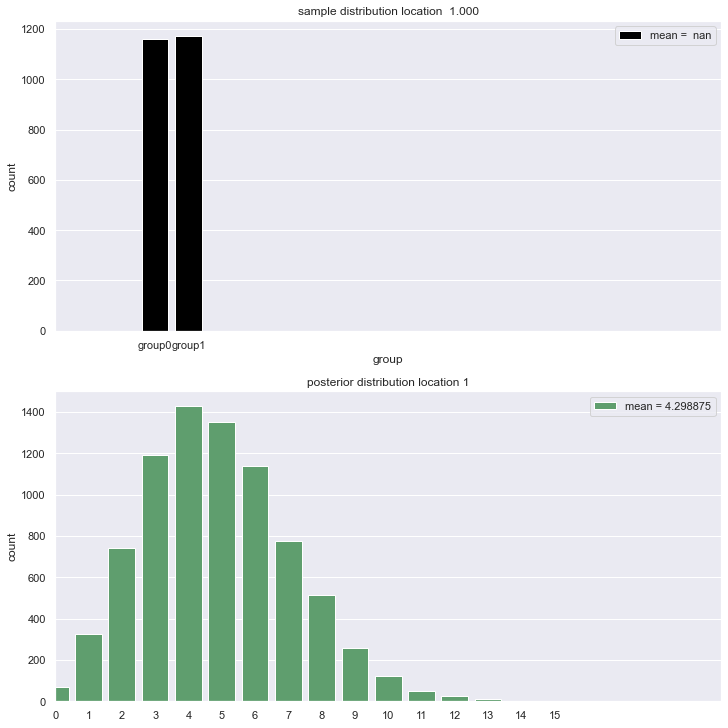

In [30]:
# Plot samples vs posterior distribution.
fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(10, 10), constrained_layout=True
)
sns.countplot(
    x=y.columns[1],
    data=y,
    color='black',
    label=f'mean = {y.query(f"group == {1}")[target].mean(): 0.3f}',
    ax=ax[0]
)
ax[0].legend(loc='upper right')
ax[0].set(
    title=f'sample distribution location {1: 0.3f}',
    xlim=(-3, 17)
)
sns.countplot(
    x=samples0,
    color=sns_c[2],
    label=f'mean = {samples1.mean()}',
    ax=ax[1]
)
ax[1].legend(loc='upper right')
ax[1].set(
    title=f'posterior distribution location {1}',
    xlim=(0, 20)
);

array([[<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'lam\ngroup0'}>,
        <AxesSubplot:title={'center':'lam\ngroup1'}>],
       [<AxesSubplot:title={'center':'difference of lam'}>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

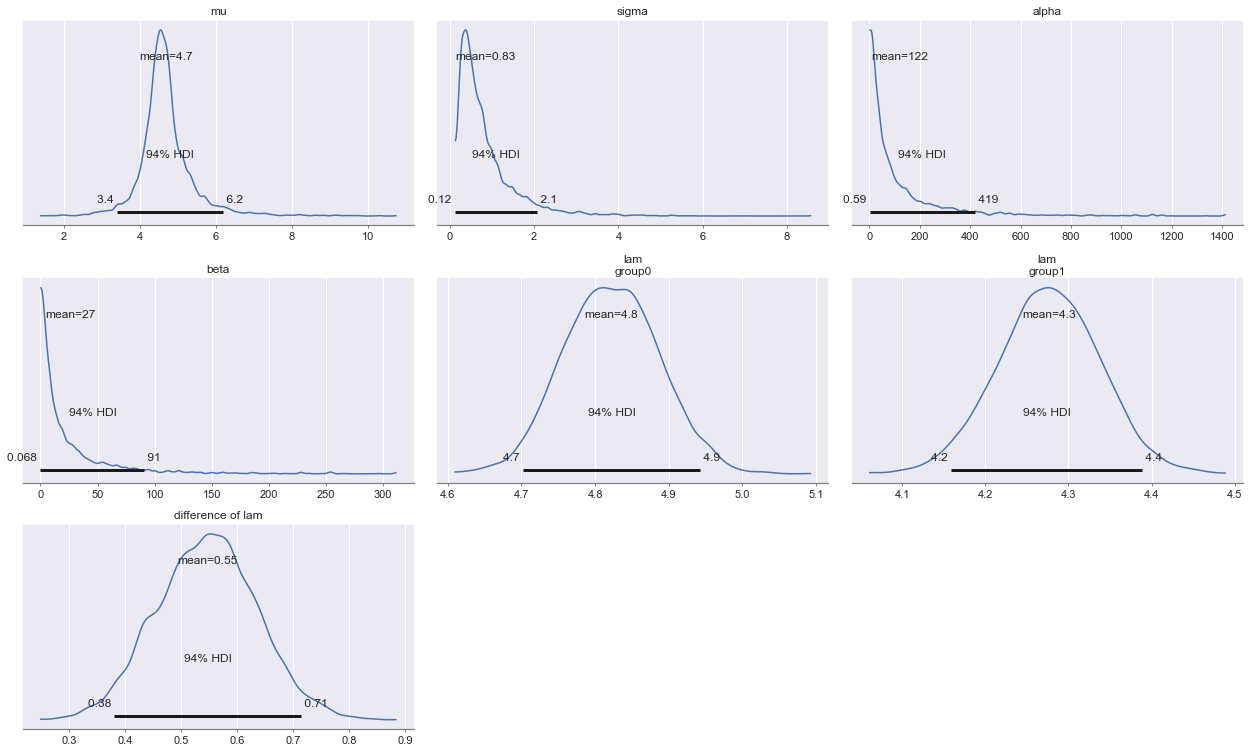

In [17]:
pm.plot_posterior(traces)

In [52]:
target_value = y[target].values
group_idx, groups = y['group'].factorize(sort=True)
COORDS = {
    'obs': y.index,
    'group': groups
}
μ_m = y[target].mean()
μ_s = y[target].std() * 2
σ_low = y[target].std()/1000
σ_high = y[target].std() * 1000
with pm.Model(coords=COORDS) as model:
    # Prior
    mu = pm.Normal('mu', mu=μ_m, sigma=μ_s, dims = 'group')
    std = pm.Uniform('std', lower=σ_low, upper=σ_high, dims = 'group')
    lam = std ** -2
    nu = pm.Exponential("ν_minus_one", 1 / 29.0, dims = 'group') + 1

    # Likehood function.
    μ = mu[group_idx]
    σ = std[group_idx]
    λ = lam[group_idx]
    v = nu[group_idx]
    likelihood = pm.StudentT(
            'likelihood',
            nu=v,
            mu=μ,
            lam=λ,
            observed=target_value,
            dims='obs'
        )

    # difference = pm.Deterministic('difference', mu[0] - mu[1])
    prior_predictive = pm.sample_prior_predictive()
    
    traces = pm.sample(
            draws=2000, chains=4, return_inferencedata=True
        )

    posterior_predictive = az.from_pymc3(
        posterior_predictive=pm.sample_posterior_predictive(trace = traces)
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν_minus_one, std, mu]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 48 seconds.


0, dim: obs, 2141 =? 2141


In [77]:
groups[0]

'group0'

In [79]:
group_id = np.unique(group_idx)

In [80]:
group_id

array([0, 1], dtype=int64)

In [104]:

def get_sample(i):
    sample = traces \
            .posterior \
            .stack(sample=('chain', 'draw')) \
            ['mu'][i, :].values
    return sample

In [109]:
METRICS = ['time_in_game_sum', 'rv_imp_sum', 'is_imp_sum']


In [111]:
from bayes import mcmc_continuous

In [58]:

sample0 = traces \
    .posterior \
    .stack(sample=('chain', 'draw')) \
    ['mu'][0, :].values

mu1 = traces \
    .posterior \
    .stack(sample=('chain', 'draw')) \
    ['mu'][1, :].values

In [98]:
def result(sample0, sample1, target):
    treatment_won = [i <= j for i,j in zip(sample0, sample1)]
    chance_to_beat_ctrl = np.mean(treatment_won)
    loss_control = [max(j - i, 0) for i,j in zip(mu0, mu1)]
    loss_treatment = [max(i - j, 0) for i,j in zip(mu0, mu1)]
    all_loss_control = [int(i)*j for i,j in zip(treatment_won, loss_control)]
    all_loss_treatment = [(1 - int(i))*j for i,j in zip(treatment_won, loss_treatment)]
    expected_loss_control = np.mean(all_loss_control)
    expected_loss_treatment = np.mean(all_loss_treatment)
    return pd.DataFrame({'chance_to_beat_ctrl':chance_to_beat_ctrl,
                'expected_loss_choosing_control':expected_loss_control,
                'expected_loss_choosing_treatment':expected_loss_treatment}, index =[target])




Chance of beating control: 0.425.


In [112]:
for target in METRICS:
    if y[target].dtype == 'float64': 
        traces, group_idx = mcmc_continuous(y, target)
        group_id = np.unique(group_idx)
        for i in group_id:
            globals()['sample' + str(i)] = get_sample(i)
        print(result(sample0, sample1, target))

KeyError: 'time_in_game_sum'

In [105]:
sample0 = get_sample(0)

In [106]:
sample1 = get_sample(1)

In [ ]:
output = pd.DataFrame()

In [107]:
result(sample0, sample1, target)

,chance_to_beat_ctrl,expected_loss_choosing_control,expected_loss_choosing_treatment
combined_ad,0.425375,0.015486,0.025542


In [90]:
expected_loss_control

0.015485800946168766

,chance_to_beat_ctrl,expected_loss_choosing_control,expected_loss_choosing_treatment
combined_ad,0.425375,0.015486,0.025542


In [68]:
print(f'Expected loss of choosing control: {round(expected_loss_control, 3)}. Expected loss of choosing treatment: {round(expected_loss_treatment, 3)}')

Expected loss of choosing control: 0.015. Expected loss of choosing treatment: 0.026


In [63]:
diff_list = map(lambda sample: np.max([sample[0]-sample[1], 0]), samples)

[(10.575333713812713, 10.226527086972537),
 (10.638176983978864, 10.269756418764588),
 (10.53825766919466, 10.341921271208706),
 (10.538482459312412, 10.322661833969834),
 (10.641878163478452, 10.527478785923423),
 (10.65163541906065, 10.591212501744069),
 (10.69501669627592, 10.540199569553476),
 (10.706540725364833, 10.594889658318591),
 (10.744758882249872, 10.463646492594586),
 (10.60918874194708, 10.173070318612883),
 (10.618759928288762, 10.372496630859409),
 (10.60399513140826, 10.311532079981834),
 (10.474565782046694, 10.439542901094482),
 (10.591797350785903, 10.395872585059509),
 (10.519591871473992, 10.334464194058818),
 (10.59865614786563, 10.350325399871313),
 (10.59865614786563, 10.350325399871313),
 (10.608717442116353, 10.28847681044531),
 (10.75585075668085, 10.468806039793632),
 (10.666074824354517, 10.259545386293974),
 (10.693902850460406, 10.314759354789333),
 (10.72125081025689, 10.290642822255464),
 (10.438170821999543, 10.511850358060013),
 (10.7399180146433, 1

In [60]:
(mu1 < mu0).mean()

0.574625

In [61]:
mu1

array([1.77906155, 1.77171568, 1.77166818, ..., 1.78289878, 1.76902649,
       1.77317155])

array([[<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'mu'}>],
       [<AxesSubplot:title={'center':'std'}>,
        <AxesSubplot:title={'center':'std'}>],
       [<AxesSubplot:title={'center':'ν_minus_one'}>,
        <AxesSubplot:title={'center':'ν_minus_one'}>]], dtype=object)

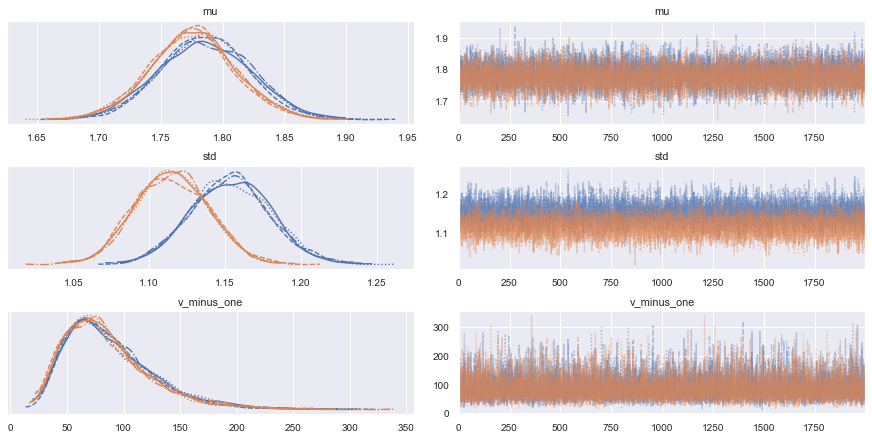

In [55]:
az.plot_trace(traces)

array([[<AxesSubplot:title={'center':'mu\ngroup0'}>,
        <AxesSubplot:title={'center':'mu\ngroup1'}>,
        <AxesSubplot:title={'center':'std\ngroup0'}>],
       [<AxesSubplot:title={'center':'std\ngroup1'}>,
        <AxesSubplot:title={'center':'ν_minus_one\ngroup0'}>,
        <AxesSubplot:title={'center':'ν_minus_one\ngroup1'}>]],
      dtype=object)

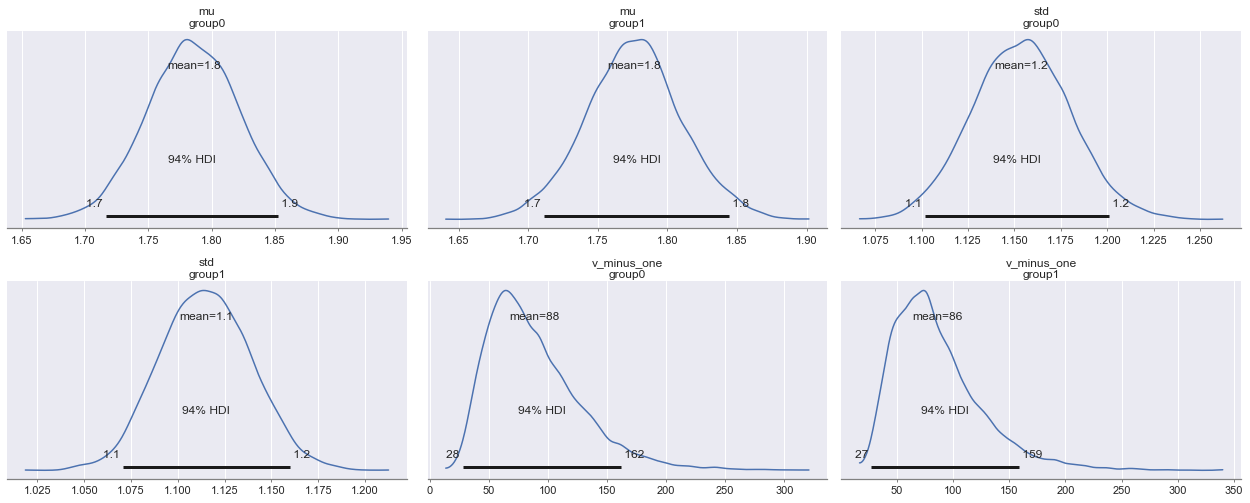

In [53]:
az.plot_posterior(traces)

In [54]:
# Set location.
lam0 = traces \
    .posterior \
    .stack(sample=('chain', 'draw')) \
    ['lam'][0, :].values

lam1 = traces \
    .posterior \
    .stack(sample=('chain', 'draw')) \
    ['lam'][1, :].values

KeyError: 'lam'

### The r_hat denotes the Gelman-Rubin test, which indicates convergence of the chains. Values close to 1.0 mean convergence.
